# **CASO DE USO 2**
*Creación de modelos de aprendizaje automático para detección de ciberataques*

## 1. Bibliotecas necesarias

In [2]:
# Bibliotecas generales
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statistics
import sklearn
import time
import os
from collections import Counter
from collections import defaultdict

# Estandarización
from sklearn.preprocessing import StandardScaler

# División del dataset en un conjunto de entrenamiento y en un conjunto de test
from sklearn.model_selection import train_test_split

# Sobremuestreo y submuestreo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

# Validación cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Bibliotecas de Algoritmos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Métricas de precisión
from sklearn.metrics import accuracy_score, confusion_matrix, zero_one_loss

# Imprimir datos tabulados
from tabulate import tabulate

# Almacenar los modelos
import pickle

## 2. Creación de funciones que se utilizarán  
Las funciones que no se explican aquí están detalladas en el jupyter notebook del caso de uso 1.

### 2.1 Estandarización

In [3]:
def performStandardization(X_train):
    # Proceso de estandarización de las características donde se centran alrededor de cero (media = 0) y se escalan para tener una varianza unitaria (desviación estándar = 1).
    # Luego, este objeto final (result) se ajustará a los datos de entrenamiento X_train para calcular la media y la desviación estándar de cada característica.
    result = StandardScaler().fit(X_train)
    return result

### 2.2 Balanceo del conjunto de datos
***Overfitting vs underfitting***

In [4]:
# Función que recibe todo el conjunto "X" de características y todo el conjunto "y" de muestras clasificadas, y
# realiza un balance de los datos dependiendo de si el remuestreo (resample) es de oversampling o de undersampling.
def balanceDataset(X, y, resample):
    
    if (resample == "o"):
        # Aplicamos técnica de oversampling
        smote = SMOTE(random_state=42)
        X, y = smote.fit_resample(X, y)
    
    elif (resample == "u"):
        # Aplicamos técnica de undersampling
        nearmiss = NearMiss(version=1)
        X, y = nearmiss.fit_resample(X, y)
    
    return X, y

### 2.3 One-Hot Encoding

One Hot Encoding es una forma común de preprocesar características categóricas para modelos de aprendizaje automático. Este tipo de codificación crea una nueva característica binaria para cada categoría posible y asigna un valor de 1 a la característica de cada muestra que corresponde a su categoría original. Las características o variables categóricas (también llamadas simbólicas) son variables que representan categorías o clases discretas que no tienen un orden inherente. En nuestro dataset, estas variables podrían incluir, por ejemplo, el tipo de protocolo de red utilizado (TCP, UDP), el tipo de servicio (HTTP, FTP, etc.), entre otros. Estas variables no pueden ser tratadas como números y generalmente se codifican utilizando técnicas como *One-Hot Encoding*.

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*ggtP4a5YaRx6l09KQaYOnw.png" alt="TrainTestSplit" width="900">

Fuente: https://towardsdatascience.com

Para aplicar la técnica de ***One Hot Encoding*** emplearemos la función *pandas.get_dummies*; una función de la biblioteca pandas que se utiliza para realizar One-Hot Encoding en variables categóricas. Esta función toma una variable categórica como entrada y crea una matriz de variables dummy (binarias) para cada categoría única presente en esa variable categórica, tal y como se puede observar en la ilustración anterior.

## 3. Carga del conjunto de datos

In [5]:
for dirname, _, filenames in os.walk('C:/UOC/jtripos/TFG/CU2/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/UOC/jtripos/TFG/CU2/kddcup.names
C:/UOC/jtripos/TFG/CU2/KDDTest+.txt
C:/UOC/jtripos/TFG/CU2/KDDTrain+.txt
C:/UOC/jtripos/TFG/CU2/training_attack_types.txt


In [6]:
dataPath = 'C:/UOC/jtripos/TFG/CU2/'
trainDataset = pd.read_csv('C:/UOC/jtripos/TFG/CU2/KDDTrain+.txt')
testDataset = pd.read_csv('C:/UOC/jtripos/TFG/CU2/KDDTest+.txt')

## 4. Exploración del conjunto de datos

In [7]:
trainDataset.shape

(125972, 43)

In [8]:
testDataset.shape

(22543, 43)

In [9]:
trainDataset.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


Podemos observar que el conjunto de datos no contiene la descripción de las columnas. Las añadimos atendiendo a la descripción proporcionada por el dataset NSL-KDD.

In [10]:
features = (['duration',
            'protocol_type',
            'service',
            'flag',
            'src_bytes',
            'dst_bytes',
            'land',
            'wrong_fragment',
            'urgent',
            'hot',
            'num_failed_logins',
            'logged_in',
            'num_compromised',
            'root_shell',
            'su_attempted',
            'num_root',
            'num_file_creations',
            'num_shells',
            'num_access_files',
            'num_outbound_cmds',
            'is_host_login',
            'is_guest_login',
            'count',
            'srv_count',
            'serror_rate',
            'srv_serror_rate',
            'rerror_rate',
            'srv_rerror_rate',
            'same_srv_rate',
            'diff_srv_rate',
            'srv_diff_host_rate',
            'dst_host_count',
            'dst_host_srv_count',
            'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate',
            'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate',
            'dst_host_serror_rate',
            'dst_host_srv_serror_rate',
            'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate',
            'attack',
            'level'
            ])

In [11]:
trainDataset.columns = features
testDataset.columns = features

In [12]:
trainDataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [13]:
testDataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
3,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
4,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,normal,21


In [14]:
trainDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [15]:
display(trainDataset.describe())

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,...,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,...,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


### 4.1 Clasificación del tráfico de red en el dataset de entrenamiento

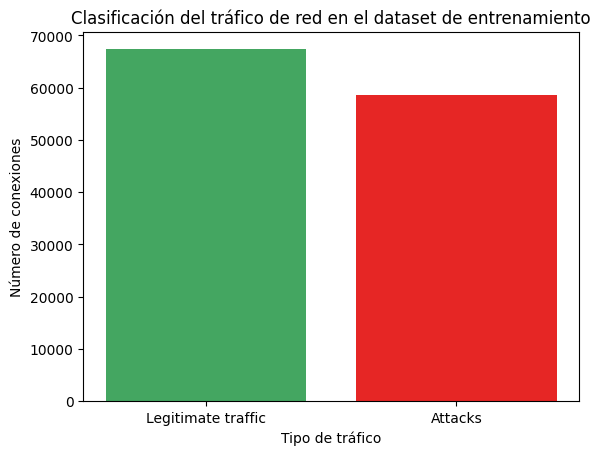

In [16]:
isAttack = []

for i in trainDataset.attack :
  if i == 'normal':
    isAttack.append('0')
  else:
    isAttack.append('1')


labelsGraph = ['Legitimate traffic', 'Attacks']
legitimateTraffic = isAttack.count('0')
attacksTraffic = isAttack.count('1')
allTrafic = [legitimateTraffic, attacksTraffic]

plt.bar(labelsGraph, allTrafic, color = ['#44A661', '#E62625'])
plt.title('Clasificación del tráfico de red en el dataset de entrenamiento')
plt.xlabel('Tipo de tráfico')
plt.ylabel('Número de conexiones')
plt.show()

In [17]:
print(Counter(isAttack))

Counter({'0': 67342, '1': 58630})


### 4.2 Clasificación del tráfico de red en el dataset de test

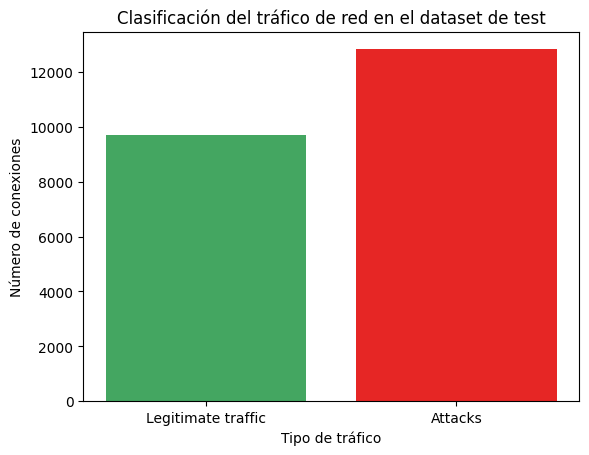

In [18]:
isAttackTest = []

for i in testDataset.attack :
  if i == 'normal':
    isAttackTest.append('0')
  else:
    isAttackTest.append('1')


labelsGraph = ['Legitimate traffic', 'Attacks']
legitimateTrafficTest = isAttackTest.count('0')
attacksTrafficTest = isAttackTest.count('1')
allTraficTest = [legitimateTrafficTest, attacksTrafficTest]

plt.bar(labelsGraph, allTraficTest, color = ['#44A661', '#E62625'])
plt.title('Clasificación del tráfico de red en el dataset de test')
plt.xlabel('Tipo de tráfico')
plt.ylabel('Número de conexiones')
plt.show()

In [19]:
print(Counter(isAttackTest))

Counter({'1': 12832, '0': 9711})


### 4.3 Exploración de los diferentes tipos de ataques existentes en ambos datasets

Para ello, emplearemos la característica 'attack' de nuestro dataset, y mostraremos los diferentes tipos de ataques y que cantidad existe de cada uno de ellos en cada dataset (entrenamiento y test).

**4.3.1 Conjunto de datos de entrenamiento**

In [20]:
trainDataset['attack'].value_counts()

attack
normal             67342
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

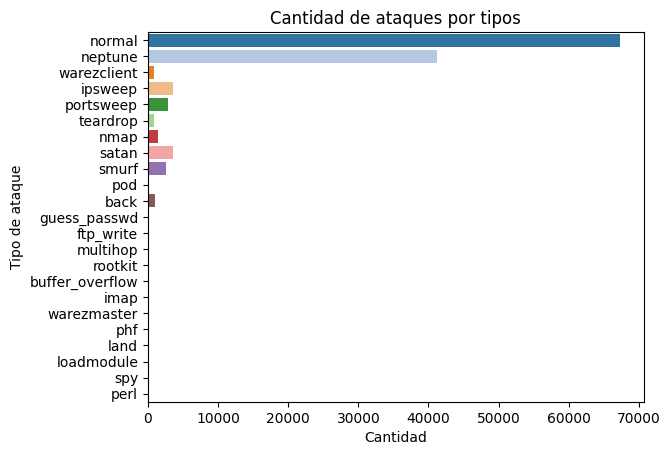

In [21]:
sns.countplot(y=trainDataset.attack, palette='tab20', hue=trainDataset.attack, legend=False)
plt.title('Cantidad de ataques por tipos')
plt.xlabel('Cantidad')
plt.ylabel('Tipo de ataque')
plt.show()

**4.3.2 Conjunto de datos de test**

In [22]:
testDataset['attack'].value_counts()

attack
normal             9711
neptune            4656
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: count, dtype: int64

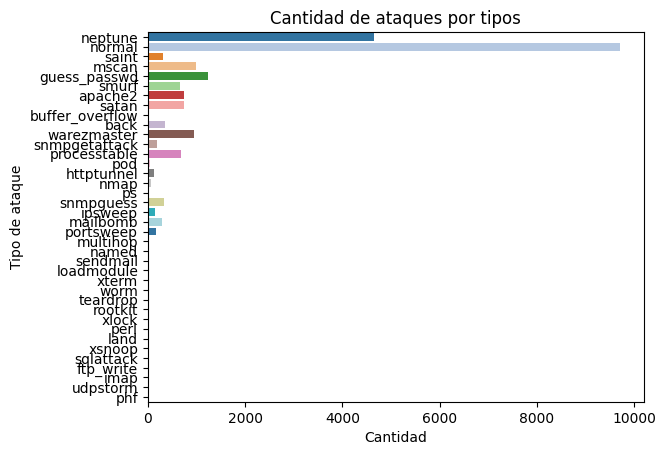

In [23]:
sns.countplot(y=testDataset.attack, palette='tab20', hue=testDataset.attack, legend=False)
plt.title('Cantidad de ataques por tipos')
plt.xlabel('Cantidad')
plt.ylabel('Tipo de ataque')
plt.show()

In [24]:
# Observamos el protocolo utilizado en cada uno de los diferentes ataques existentes en el dataset de entrenamiento
pd.crosstab(trainDataset.attack, trainDataset.protocol_type)

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


In [25]:
# Observamos el protocolo utilizado en cada uno de los diferentes ataques existentes en el dataset de test
pd.crosstab(testDataset.attack, testDataset.protocol_type)

protocol_type,icmp,tcp,udp
attack,,,
apache2,0,737,0
back,0,359,0
buffer_overflow,0,20,0
ftp_write,0,3,0
guess_passwd,0,1231,0
httptunnel,0,133,0
imap,0,1,0
ipsweep,141,0,0
land,0,7,0


Llegados a este punto es importante darnos cuenta que el dataset de entrenamiento (*KDDTrain+.txt*) contiene 22 tipos diferentes de ataques mientras que el dataset de test (*KDDTest+.txt*) contiene 37. Esto se traduce en que el conjunto de datos de test posee 15 tipos de ataques adicionales, no presentes en el conjunto de datos con el que entrenaremos a nuestros modelos. Pero todo esto tiene sentido, ya que, estos conjuntos de datos fueron minuciosamente pensados y diseñados justamente para probar qué tan bien generaliza los datos de entrenamiento el modelo entrenado. Si el modelo resultante es capaz de realizar predicciones correctas sobre el tipo de tráfico que le entre, significa que este modelo aprendió con éxito algunas propiedades generalizables de cada grupo de ataques que le permitieron clasificar correctamente otros tipos de ataques nunca antes vistos.

## 5. Preparación de los datos, también llamado **preprocesamiento de datos**

### 5.1 Planteamiento de la estrategia a seguir

Según la documentación oficial del dataset, todos estos ataques anteriormente mencionados se encuentran agrupados en cuatro categorías:
1. **Ataques de denegación de servicio** --> `dos`. Un ataque de denegación de servicio (DoS) es un ataque destinado a un sistema de computadoras o red que causa que un servicio o recurso sea inaccesible para los usuarios legítimos. Los ataques DoS logran esto inundando al objetivo con tráfico o enviándole información que desencadene una falla.

2. **Ataques remoto a local** --> `r2l`. Con este tipo de ataques, el atacante busca obtener acceso no autorizado a una máquina víctima de la red.

3. **Ataque de usuario root (escalada de privilegios)** --> `u2r`. Este ataque se lanza para obtener ilegalmente privilegios de root al acceder legalmente a una máquina local.

4. **Ataques de sondeo de fuerza bruta** --> `probe`. El atacante escanea una máquina o un dispositivo de red para determinar las posibles vulnerabilidades existentes en la red que luego puedan ser explotadas con el objetivo de comprometer el sistema.

En este caso de uso se diseñará un modelo que sea capaz de clasificar el tráfico de red en cinco categorías: las cuatro anteriores (dos, r2l, u2r y probe) y la categoría de tráfico legítimo (legitimate).

En la clasificación de los ataques, hemos visto que existen cuatro grupos principales pero, sin embargo, aún no hemos visto que tipos de ataques pertenecen a cada grupo. Para ello, nos serviremos de la documentación oficial del dataset, donde podemos observar que la asignación de etiquetas de grupo de ataque a los diferentes tipos de ataques se especifica en el archivo *training_attack_types.txt* (puede encontrarse dentro de este repositorio).

Vamos a observar estas categorías en nuestro dataset:

In [26]:
attackGroups = defaultdict(list)
attackGroups['legitimate'].append('normal')

with open(dataPath + 'training_attack_types.txt', 'r') as attackTypes:
    for line in attackTypes.readlines():
        attack, attackGroup = line.strip().split(' ')
        attackGroups[attackGroup].append(attack)

In [27]:
for key, value in attackGroups.items():
    print(key, value)

legitimate ['normal']
dos ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'snmpgetattack', 'teardrop', 'udpstorm']
u2r ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
r2l ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']
probe ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan', 'worm']


Aquí sabemos los diferentes grupos de ataques que posee nuestro dataset y los diferentes tipos de ataques que posee cada uno. Ahora nos falta etiquetar a cada uno de los ataques con el grupo al que pertecene. Para ello, se invertirá el diccionario de cara a preparar los datos correctamente para el entrenamiento posterior del modelo.

In [28]:
attackToGroup = {v: k for k in attackGroups for v in attackGroups[k]}

In [29]:
attackToGroup

{'normal': 'legitimate',
 'apache2': 'dos',
 'back': 'dos',
 'land': 'dos',
 'mailbomb': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'processtable': 'dos',
 'smurf': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'udpstorm': 'dos',
 'buffer_overflow': 'u2r',
 'httptunnel': 'u2r',
 'loadmodule': 'u2r',
 'perl': 'u2r',
 'ps': 'u2r',
 'rootkit': 'u2r',
 'sqlattack': 'u2r',
 'xterm': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'multihop': 'r2l',
 'named': 'r2l',
 'phf': 'r2l',
 'sendmail': 'r2l',
 'snmpguess': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'worm': 'probe',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'ipsweep': 'probe',
 'mscan': 'probe',
 'nmap': 'probe',
 'portsweep': 'probe',
 'saint': 'probe',
 'satan': 'probe'}

In [30]:
# Añadimos los grupos de ataques a nuestro dataset de entrenamiento y al de test
trainDataset['attack_group'] = trainDataset['attack'].map(lambda x: attackToGroup[x])
testDataset['attack_group'] = trainDataset['attack'].map(lambda x: attackToGroup[x])

In [31]:
# Observamos como se ha añadido correctamente la columna 'attack_group' que representa el grupo al que pertenece cada ataque
trainDataset.head(20)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_group
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,legitimate
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,legitimate
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,legitimate
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21,dos
5,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,dos
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,dos
7,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,dos
8,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21,dos
9,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21,dos


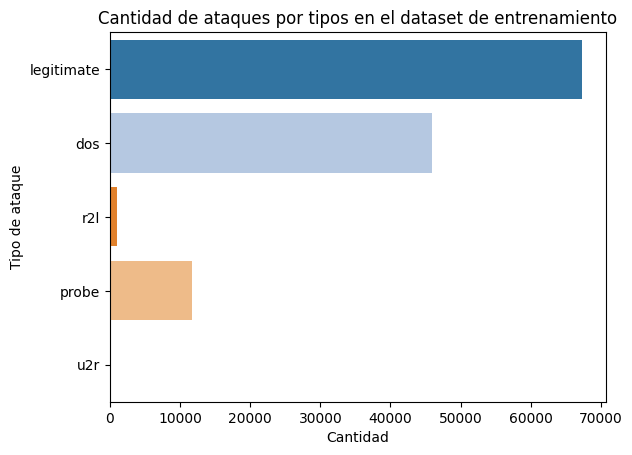

In [32]:
sns.countplot(y=trainDataset.attack_group, palette='tab20', hue=trainDataset.attack_group, legend=False)
plt.title('Cantidad de ataques por tipos en el dataset de entrenamiento')
plt.xlabel('Cantidad')
plt.ylabel('Tipo de ataque')
plt.show()

In [33]:
trainDataset['attack_group'].value_counts()

attack_group
legitimate    67342
dos           45927
probe         11656
r2l             995
u2r              52
Name: count, dtype: int64

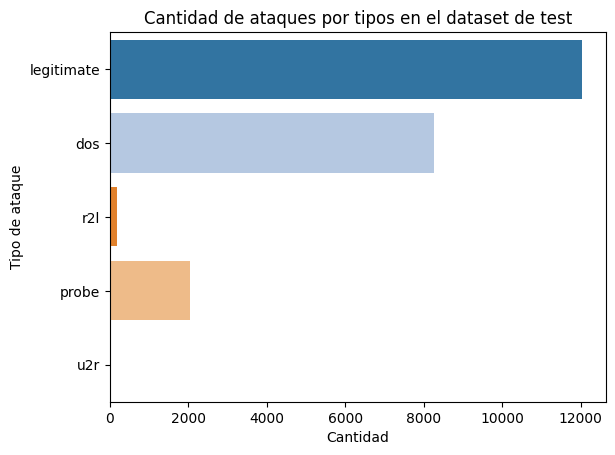

In [34]:
sns.countplot(y=testDataset.attack_group, palette='tab20', hue=testDataset.attack_group, legend=False)
plt.title('Cantidad de ataques por tipos en el dataset de test')
plt.xlabel('Cantidad')
plt.ylabel('Tipo de ataque')
plt.show()

In [35]:
testDataset['attack_group'].value_counts()

attack_group
legitimate    12041
dos            8271
probe          2037
r2l             183
u2r              11
Name: count, dtype: int64

### 5.2 División entre las características y el objetivo de ambos datasets

In [36]:
X_train_pre = trainDataset.drop(['attack_group','attack'], axis=1)
y_train = trainDataset['attack_group']

X_test_pre = testDataset.drop(['attack_group','attack'], axis=1)
y_test = testDataset['attack_group']

### 5.3 Variables simbólicas vs variables continuas

En el conjunto de datos NSL-KDD las variables pueden clasificarse como simbólicas (también conocidas como categóricas) o continuas (también conocidas como numéricas).

1. **Variables simbólicas (categóricas)**: Estas son variables que representan categorías o clases discretas que no tienen un orden inherente. En nuestro dataset, estas variables podrían incluir, por ejemplo, el tipo de protocolo de red utilizado (TCP, UDP), el tipo de servicio (HTTP, FTP, etc.), entre otros. Estas variables no pueden ser tratadas como números y generalmente se codifican utilizando técnicas como *One-Hot Encoding*. El *One-Hot Encoding* transforma cada valor categórico en un vector binario que representa la presencia o ausencia de esa categoría.

    Aplicado a nuestro dataset, un ejemplo de utilización de la técnica *One-Hot Encoding* podría ser para representar el tipo de protocolo de red utilizado. Con *One-Hot Encoding*, convertiremos cada valor posible del tipo de protocolo de red utilizado en un vector binario como el siguiente:
    - TCP:[1,0,0]
    - UDP:[0,1,0]
    - ICMP:[0,0,1]

2. **Variables continuas (numéricas)**: Estas son variables que representan cantidades que pueden tomar un rango infinito de valores dentro de un intervalo continuo. En nuestro dataset, por ejemplo, estas variables podrían incluir el tiempo de duración de una conexión, el número de bytes transferidos, la tasa de transferencia de datos, entre otros. Estas variables se pueden manipular matemáticamente y esto es importante porque son las que se utilizan para realizar análisis estadísticos y para entrenar a modelos de predicción.

Es importante comprender esta distinción al analizar y modelar datos, ya que el tratamiento de cada tipo de variable requiere diferentes enfoques y técnicas.

In [37]:
trainDataset['protocol_type'].value_counts()

protocol_type
tcp     102688
udp      14993
icmp      8291
Name: count, dtype: int64

In [38]:
variableNames = defaultdict(list)

with open(dataPath + 'kddcup.names', 'r') as kddCupNames:
    for line in kddCupNames.readlines()[1:]:
        variableName, variableType = line.strip()[:-1].split(': ')
        variableNames[variableType].append(variableName)

In [39]:
for key, value in variableNames.items():
    print(key, value)

continuous ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
symbolic ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']


### 5.4 Variables simbólicas puras vs variables simbólicas binarias

Otra aspecto importante que podemos observar dentro de las variables simbólicas es que existen variables simbólicas que tienen varias categorías internas (por ejemplo, la variable **service** puede tomar varios valores: http, private, domain_u, smtp, tftp_u, entre otros), y variables simbólicas que solo toman dos valores (variables binarias) como, por ejemplo, la variable **logged_in** que solo toma los valores 0 y 1. Es por ello que subdividiremos, a su vez, las variables simbólicas en variables simbólicas nominales (nominal) y variables simbólicas binarias (binary), ya que, las preprocesaremos de forma diferente.

In [40]:
# Observamos como la variable simbólica 'service' puede tomar varios valores
trainDataset['service'].value_counts()

service
http         40338
private      21853
domain_u      9043
smtp          7313
ftp_data      6859
             ...  
tftp_u           3
http_8001        2
aol              2
harvest          2
http_2784        1
Name: count, Length: 70, dtype: int64

In [41]:
# Observamos como la variable simbólica 'logged_in' solo toma dos valores
trainDataset['logged_in'].value_counts()

logged_in
0    76120
1    49852
Name: count, dtype: int64

Llegados a este punto, ya hemos observado cuáles son las variables simbólicas de nuestro dataset y cuáles son las continuas. Dentro de las continuas, hemos diferenciado las variables nominales de las binarias. El siguiente paso es convertir las variables nominales en binarias, con el objetivo de permitir que los algoritmos de aprendizaje automático que emplearemos más adelante, trabajen con estas variables simbólicas a través de un formato que puedan entender y procesar de manera efectiva.

Para lograr esto, lo primero que haremos será concatenar los dataset de características de entrenamiento y de test, ya que, pueden existir algunos valores de variables simbólicas que aparezcan en un conjunto de datos y no en el otro, generarando de esta manera variables binarias independientes para cada uno de ellos, lo que daría como resultado inconsistencias en las columnas de ambos conjuntos de datos.

In [42]:
mergedDataset = pd.concat([X_train_pre, X_test_pre])
continuousVariables = variableNames['continuous']

# Eliminamos la variable 'root_shell' porque, como se puede observar en el siguiente fragmento de código, se trata de una variable binaria (solo toma los valores 0 y 1).
continuousVariables.remove('root_shell')

In [43]:
trainDataset['root_shell'].value_counts()

root_shell
0    125803
1       169
Name: count, dtype: int64

In [44]:
binarySymbolicVariables = ['land','logged_in','root_shell','su_attempted','is_host_login','is_guest_login']
nominalSymbolicVariables = [variable for variable in variableNames['symbolic'] if variable not in binarySymbolicVariables]

Obtenemos las variables simbólicas nominales que luego convertiremos a binarias.

In [45]:
# Observamos aquellas variables simbólicas nominales
nominalSymbolicVariables

['protocol_type', 'service', 'flag']

In [46]:
# Generamos para cada una de las variables simbólicas nominales, extraídas en el fragmento de código anterior, una nueva característica binaria para cada categoría posible y asignamos un valor de 1 a la característica de cada muestra que corresponda a su categoría original.
mergedDatasetWithOneHot = pd.get_dummies(mergedDataset, columns=variableNames['symbolic'], drop_first=True)

# Creamos los índices para los conjuntos de datos de entrenamiento y prueba
trainIndices = range(len(X_train_pre))
testIndices = range(len(X_train_pre), len(X_train_pre) + len(X_test_pre))

# Dividimos las características y el objetivo de ambos datasets nuevamente. Para ello, extraeremos las filas correspondientes a los índices definidos anteriormente.
X_train = mergedDatasetWithOneHot.iloc[trainIndices]
X_test = mergedDatasetWithOneHot.iloc[testIndices]

In [47]:
dummyVariables = [variable for variable in X_train if variable not in mergedDataset]

Observamos las variables binarias que se crearon para representar las categorías de las variables nominales.

In [48]:
dummyVariables

['protocol_type_tcp',
 'protocol_type_udp',
 'service_X11',
 'service_Z39_50',
 'service_aol',
 'service_auth',
 'service_bgp',
 'service_courier',
 'service_csnet_ns',
 'service_ctf',
 'service_daytime',
 'service_discard',
 'service_domain',
 'service_domain_u',
 'service_echo',
 'service_eco_i',
 'service_ecr_i',
 'service_efs',
 'service_exec',
 'service_finger',
 'service_ftp',
 'service_ftp_data',
 'service_gopher',
 'service_harvest',
 'service_hostnames',
 'service_http',
 'service_http_2784',
 'service_http_443',
 'service_http_8001',
 'service_imap4',
 'service_iso_tsap',
 'service_klogin',
 'service_kshell',
 'service_ldap',
 'service_link',
 'service_login',
 'service_mtp',
 'service_name',
 'service_netbios_dgm',
 'service_netbios_ns',
 'service_netbios_ssn',
 'service_netstat',
 'service_nnsp',
 'service_nntp',
 'service_ntp_u',
 'service_other',
 'service_pm_dump',
 'service_pop_2',
 'service_pop_3',
 'service_printer',
 'service_private',
 'service_red_i',
 'service_rem

En el siguiente fragmento de código, podemos observar cómo existen 11 valores posibles para la variable simbólica llamada 'flag', tanto en el conjunto de datos de entrenmiento como en el conjunto de datos de test (ambos sin preprocesar): SF, S0, REJ, RSTR, RSTO, S1, SH, S2, RSTOSO, S3 y OTH.

In [49]:
X_train_pre['flag'].value_counts()

flag
SF        74944
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
S1          365
SH          271
S2          127
RSTOS0      103
S3           49
OTH          46
Name: count, dtype: int64

In [50]:
X_test_pre['flag'].value_counts()

flag
SF        14875
REJ        3849
S0         2013
RSTO        773
RSTR        669
S3          249
SH           73
S1           21
S2           15
OTH           4
RSTOS0        2
Name: count, dtype: int64

La explicación de cada una de las banderas (flags) se puede observar en la siguiente tabla:

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*SJWwl1xtSvZVs7IRzc4yng.jpeg" alt="TrainTestSplit" width="900">

Fuente: https://towardsdatascience.com/a-deeper-dive-into-the-nsl-kdd-data-set-15c753364657

In [51]:
X_train['flag_S0']

0         False
1          True
2         False
3         False
4         False
          ...  
125967     True
125968    False
125969    False
125970     True
125971    False
Name: flag_S0, Length: 125972, dtype: bool

### 5.5 Estandarización de los datos

En la siguiente ejecución de código, observamos que algunas características del dataset tienen distribuciones muy diferentes, lo que puede influir en nuestros resultados si aplicamos, por ejemplo, un método de clasificación que se basa en la distancia. Para solucionar esto emplearemos la técnica de estandarización, que, como ya hemos visto en el caso de uso 1, se trata de un proceso que cambia la escala de una serie de datos para que tenga una media de 0 y una desviación estándar de 1.

In [52]:
X_train.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.022688,0.000111,0.204411,0.001222,0.279253,0.001342,0.001103,...,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.253531,0.014366,2.149977,0.045239,23.942137,0.036603,0.045155,...,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,3.000000,3.000000,77.000000,5.000000,7479.000000,1.000000,2.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [53]:
# Aplicamos la técnica de estandarización al conjunto de entrenamiento
standarization = performStandardization(X_train[continuousVariables])

# Partiendo de los datos de X_train y X_test, los transformamos según las estadísticas de la transformación de estandarización calculada en la línea anterior.
# Esta transformación ajustará las variables continuas para que tengan una media de 0 y una desviación estándar de 1.
X_train.loc[:, continuousVariables] = standarization.transform(X_train.loc[:, continuousVariables]).astype('int64')
X_test.loc[:, continuousVariables] = standarization.transform(X_test.loc[:, continuousVariables]).astype('int64')


### 5.6 Análisis de la relación entre las características del conjunto de datos

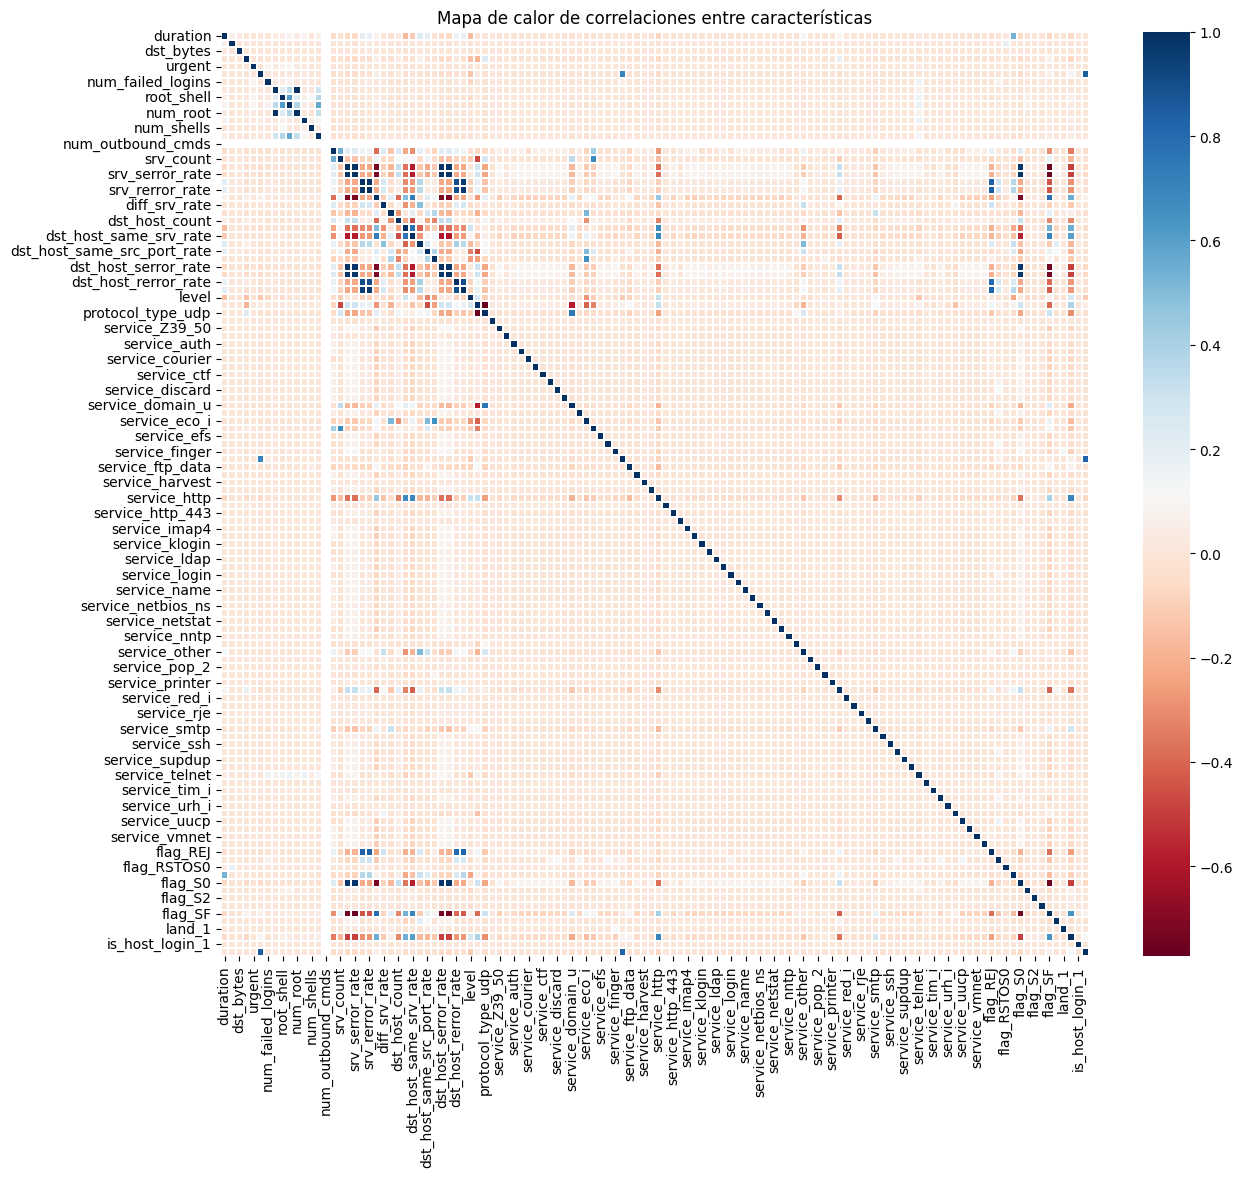

In [54]:
# Mapa de calor de correlación entre características del dataset
corrMatrix = X_train.corr(numeric_only=True)
plt.figure(figsize=(14, 12))
sns.heatmap(corrMatrix, cmap='RdBu', linewidths = 0.1)
plt.title('Mapa de calor de correlaciones entre características')
plt.show()

## 6. Versiones del dataset

### 6.1 Dataset sin balancear

In [55]:
# Aprovechamos todas las modificaciones realizadas hasta esta línea
X_train = X_train
X_test = X_test
y_train = y_train
y_test = y_test

### 6.2 Dataset balanceado con sobremuestreo

In [56]:
# Aplicamos la técnica de sobremuestreo.
X_train_OS, y_train_OS = balanceDataset(X_train, y_train, "o")
X_test_OS, y_test_OS = balanceDataset(X_test, y_test, "o")

### 6.3 Dataset balanceado con submuestreo

In [57]:
X_train_US, y_train_US = balanceDataset(X_train, y_train, "o")
X_test_US, y_test_US = balanceDataset(X_test, y_test, "o")

## 7. Desarrollo de diferentes modelos

### 7.1 Creación de un modelo de aprendizaje automático aplicando el algoritmo "Árboles de decisión" (Decision Tree) sobre dataset sin balancear

In [58]:
model = DecisionTreeClassifier()                # Seleccionamos el algoritmo "Árboles de decisión" 

startTime = time.time()                         # Inicio del entrenamiento
trainingModel = model.fit(X_train, y_train)     # Entrenamiento del algoritmo "Árboles de decisión" con nuestros conjuntos de entrenamiento
endTime = time.time()                           # Fin del entrenamiento

timeSpent = endTime - startTime                 # Tiempo invertido en entrenar el modelo

kfold = KFold(7)                                                                             # Establecemos el valor de iteraciones de validación cruzada en 7
scores = cross_val_score(trainingModel, X_train, y_train, cv = kfold, scoring='accuracy')    #  Realiza validación cruzada y evalúa el rendimiento del modelo en el conjunto de datos

pred_y = model.predict(X_test)

conMat = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)

In [59]:
# Imprimirmos los resultados
print("El tiempo de entrenamiento del modelo ha sido:", timeSpent,"segundos.\n")
print("Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:\n", scores, "\n")
print("Precisión media: ", scores.mean(), "\n")       # para ver el promedio de los resultados
print("Desviación estándar de la precisión:", scores.std(), "\n")
print("Matriz de confusión para evaluar el rendimiento del modelo:\n\n", conMat, "\n")

El tiempo de entrenamiento del modelo ha sido: 0.6587963104248047 segundos.

Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:
 [0.99822183 0.99716604 0.99772172 0.99811069 0.99805512 0.99794399
 0.99822183] 

Precisión media:  0.9979201727367987 

Desviación estándar de la precisión: 0.00034747513142982186 

Matriz de confusión para evaluar el rendimiento del modelo:

 [[2236 4928  878  197   32]
 [3256 7171 1255  309   50]
 [ 555 1221  197   54   10]
 [  55  103   18    5    2]
 [   5    6    0    0    0]] 



**Graficamos el árbol de decisión**

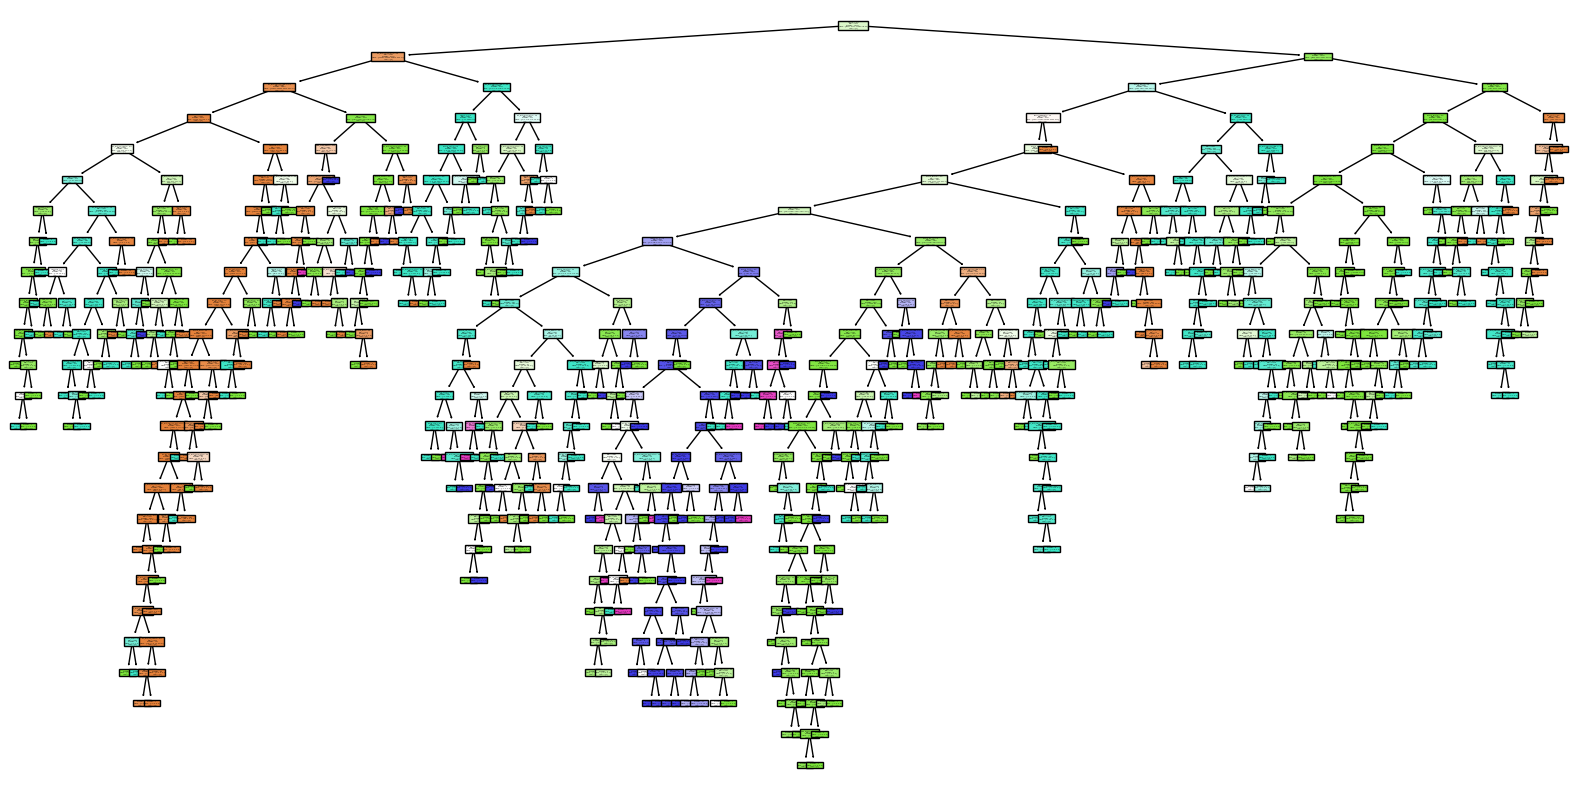

In [60]:
plt.figure(figsize=(20, 10))
plot_tree(trainingModel, filled=True, feature_names=X_train.columns, class_names=True)
plt.show()

**Guardamos el modelo creado**

In [61]:
pklFilename = "trained_models/CU2_DecisionTreeModel.pkl"

with open(pklFilename, 'wb') as file:
    pickle.dump(trainingModel, file) 

### 7.2 Creación de un modelo de aprendizaje automático aplicando el algoritmo "Árboles de decisión" (Decision Tree) sobre dataset balanceado aplicando la técnica de sobremuestreo (oversampling)

In [62]:
model = DecisionTreeClassifier()                # Seleccionamos el algoritmo "Árboles de decisión" 

startTime = time.time()                         # Inicio del entrenamiento
trainingModel = model.fit(X_train_OS, y_train_OS)     # Entrenamiento del algoritmo "Árboles de decisión" con nuestros conjuntos de entrenamiento
endTime = time.time()                           # Fin del entrenamiento

timeSpent = endTime - startTime                 # Tiempo invertido en entrenar el modelo

kfold = KFold(7)                                                                             # Establecemos el valor de iteraciones de validación cruzada en 7
scores = cross_val_score(trainingModel, X_train_OS, y_train_OS, cv = kfold, scoring='accuracy')    #  Realiza validación cruzada y evalúa el rendimiento del modelo en el conjunto de datos

pred_y = model.predict(X_test_OS)

conMat = confusion_matrix(y_test_OS, pred_y)

In [63]:
# Imprimirmos los resultados
print("El tiempo de entrenamiento del modelo ha sido:", timeSpent,"segundos.\n")
print("Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:\n", scores, "\n")
print("Precisión media: ", scores.mean(), "\n")       # para ver el promedio de los resultados
print("Desviación estándar de la precisión:", scores.std(), "\n")
print("Matriz de confusión para evaluar el rendimiento del modelo:\n\n", conMat, "\n")

El tiempo de entrenamiento del modelo ha sido: 2.19166898727417 segundos.

Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:
 [0.99679847 0.9975053  0.99835766 0.99814973 0.92501195 0.94058336
 0.8899815 ] 

Precisión media:  0.9637697087930226 

Desviación estándar de la precisión: 0.04156195323948217 

Matriz de confusión para evaluar el rendimiento del modelo:

 [[3325 6923 1228  507   58]
 [3350 6818 1303  517   53]
 [3416 6740 1214  609   62]
 [4061 6397 1176  406    1]
 [3884 7509  618   30    0]] 



In [64]:
model = DecisionTreeClassifier()                # Seleccionamos el algoritmo "Árboles de decisión" 

startTime = time.time()                         # Inicio del entrenamiento
trainingModel = model.fit(X_train_US, y_train_US)     # Entrenamiento del algoritmo "Árboles de decisión" con nuestros conjuntos de entrenamiento
endTime = time.time()                           # Fin del entrenamiento

timeSpent = endTime - startTime                 # Tiempo invertido en entrenar el modelo

kfold = KFold(7)                                                                             # Establecemos el valor de iteraciones de validación cruzada en 7
scores = cross_val_score(trainingModel, X_train_US, y_train_US, cv = kfold, scoring='accuracy')    #  Realiza validación cruzada y evalúa el rendimiento del modelo en el conjunto de datos

pred_y = model.predict(X_test_US)

conMat = confusion_matrix(y_test_US, pred_y)

In [65]:
# Imprimirmos los resultados
print("El tiempo de entrenamiento del modelo ha sido:", timeSpent,"segundos.\n")
print("Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:\n", scores, "\n")
print("Precisión media: ", scores.mean(), "\n")       # para ver el promedio de los resultados
print("Desviación estándar de la precisión:", scores.std(), "\n")
print("Matriz de confusión para evaluar el rendimiento del modelo:\n\n", conMat, "\n")

El tiempo de entrenamiento del modelo ha sido: 2.189676284790039 segundos.

Puntuaciones de precisión obtenidas en cada iteración de la validación cruzada:
 [0.99681926 0.99754688 0.99829529 0.99812894 0.92499116 0.94062494
 0.8899815 ] 

Precisión media:  0.9637697087930225 

Desviación estándar de la precisión: 0.04155873385918396 

Matriz de confusión para evaluar el rendimiento del modelo:

 [[3352 6940 1247  441   61]
 [3379 6848 1314  447   53]
 [3450 6770 1221  535   65]
 [4083 6344 1193  420    1]
 [3969 7240  832    0    0]] 



### 7.3 Automatización en la creación de varios modelos de aprendizaje aplicando diferentes algoritmos sobre el dataset sin balancear

In [66]:
# Creamos una lista de listas para los datos que contendrá la tabla de resultados
resultTable = []

# Agregamos encabezados de columna a la tabla de resultados
headers = ["Algoritmo", "Puntuación media", "Desviación estándar", "Tiempo de entrenamiento"]

# Seleccionamos los algoritmos
algorithmsToUse = []

# Algoritmos de regresión
#algorithmsToUse.append(('LinealRegression', LinearRegression()))
algorithmsToUse.append(('LogisticRegression', LogisticRegression(max_iter=700)))

# Algoritmos de clasificación
algorithmsToUse.append(('K-Nearest-Neighbors_k=2', KNeighborsClassifier(n_neighbors=2)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=3', KNeighborsClassifier(n_neighbors=3)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=4', KNeighborsClassifier(n_neighbors=4)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=5', KNeighborsClassifier(n_neighbors=5)))
algorithmsToUse.append(('K-Nearest-Neighbors_k=7', KNeighborsClassifier(n_neighbors=7)))
algorithmsToUse.append(('SupportVectorMachine', SVC()))
algorithmsToUse.append(('NaiveBayes', GaussianNB()))

# Algoritmos de agrupamiento o clustering
algorithmsToUse.append(('K-Means', KMeans()))

# Algoritmos basados en árboles de decisión
algorithmsToUse.append(('DecisionTree', DecisionTreeClassifier()))
algorithmsToUse.append(('RandomForest', RandomForestClassifier()))

# Creamos el vector que almacenará nuestros algoritmos entrenados
trainedModels = []
    
results = []
names = []

# Entrenamos a los diferentes algoritmos con nuestros conjuntos de entrenamiento
for algorithmName, algorithm in algorithmsToUse:
    # Validación cruzada
    kfold = KFold(7)
    # Medimos el tiempo de entrenamiento
    startTime = time.time()
    trainedModel = algorithm.fit(X_train, np.ravel(y_train))
    endTime = time.time()

    cvScores = cross_val_score(trainedModel, X_train, np.ravel(y_train), cv = kfold, scoring='accuracy')
    results.append(cvScores)
    names.append(algorithmName)
    
     # Limitamos la cantidad de decimales a 7
    meanScore = round(cvScores.mean(), 7)
    stdDev = round(cvScores.std(), 7)
    elapsedTime = round(endTime - startTime, 7)

    # Agregar los datos de cada algoritmo a la lista de datos de la tabla
    resultTable.append([algorithmName, meanScore, stdDev, elapsedTime])

    trainedModels.append((algorithmName, trainedModel))

# Imprimimos la tabla utilizando tabulate
print(tabulate(resultTable, headers=headers, floatfmt=".7f"))

Algoritmo                  Puntuación media    Desviación estándar    Tiempo de entrenamiento
-----------------------  ------------------  ---------------------  -------------------------
LogisticRegression                0.9887038              0.0005099                 12.3850789
K-Nearest-Neighbors_k=2           0.9972692              0.0002886                  0.1245842
K-Nearest-Neighbors_k=3           0.9975074              0.0002171                  0.1225905
K-Nearest-Neighbors_k=4           0.9973724              0.0002237                  0.1235859
K-Nearest-Neighbors_k=5           0.9971184              0.0002421                  0.1285701
K-Nearest-Neighbors_k=7           0.9969120              0.0003779                  0.1176064
SupportVectorMachine              0.9900851              0.0006680                226.1421571
NaiveBayes                        0.6094688              0.0945449                  0.2541537
K-Means                           0.0000000              0.0